In [16]:
import numpy as np
import matplotlib.pyplot as plt

import adaptivealgo.cli.policy_iter as pi
from adaptivealgo.lib.simulator import Simulator
from adaptivealgo.lib.env import Environment
import adaptivealgo.cli.simulate_policy as sim
from adaptivealgo.lib.util import trim_state, get_ttl

In [17]:
n_links = 4
f_thresh = 0.4
actions = [0.1, 0.2, 0.3, 0.4, 0.5]
alpha = 1.0
gamma = 0.2
tol = 1e-6

n_episodes = 10_000

In [21]:
def get_heuristic_action(state: list[int]):
    """
    Returns the action with highest probability that can produce
    a link which can live until the required number of links
    have been generated

    :param list[int] state: The current links in memory
    :returns int: The index of the action to take
    """
    
    state = trim_state(state, n_links)
    req_steps = n_links - len(state)
    min_diff = np.inf
    best_action = 0

    for action_idx, action in enumerate(actions):
        new_ttl = get_ttl(action, alpha, f_thresh, gamma)
        if new_ttl >= req_steps and new_ttl - req_steps < min_diff:
            min_diff = new_ttl - req_steps
            best_action = action_idx
    
    return best_action

def get_heuristic_policy():
    """
    Returns a policy that always takes the action with the highest
    probability of producing a link that can live until the required
    number of links have been generated

    :returns dict: The heuristic policy
    """

    result = {}
    heuristic_env = Environment(n_links, actions, f_thresh, alpha, gamma)
    for state in heuristic_env.states:
        result[str(state)] = get_heuristic_action(state)

    return result

In [22]:
policy, i = pi.find_policy(n_links, f_thresh, actions, alpha, gamma, tol)
opt_policy: dict = policy["policy"]
print(f"Policy iteration took {i} iterations")

simulator = Simulator(opt_policy, n_links, f_thresh, actions, alpha, gamma)
opt_samples = sim.gen_policy_samples(simulator, n_episodes)
print(f"Mean runtime: {int(np.mean(opt_samples))} steps")

Policy iteration took 2 iterations
Mean runtime: 25 steps


In [27]:
heuristic_policy = get_heuristic_policy()
simulator = Simulator(heuristic_policy, n_links, f_thresh, actions, alpha, gamma)
heuristic_samples = sim.gen_policy_samples(simulator, n_episodes)
print(f"Mean runtime for heuristic policy: {int(np.mean(heuristic_samples))} steps")

Mean runtime for heuristic policy: 58 steps


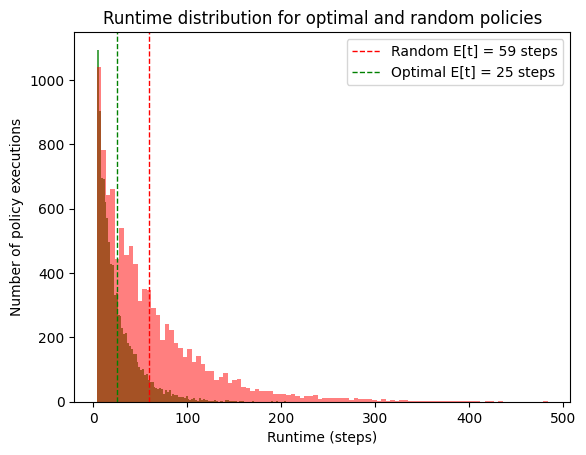

In [25]:
plt.hist(opt_samples, bins=100, color='g', alpha=0.7)
plt.hist(heuristic_samples, bins=100, color='r', alpha=0.5)

plt.axvline(np.mean(heuristic_samples), color='r', linestyle='--', linewidth=1)
plt.axvline(np.mean(opt_samples), color='g', linestyle='--', linewidth=1)

plt.title('Runtime distribution for optimal and random policies')
plt.xlabel('Runtime (steps)')
plt.ylabel('Number of policy executions')

plt.legend([f'Random E[t] = {int(np.mean(heuristic_samples))} steps', f'Optimal E[t] = {int(np.mean(opt_samples))} steps'])
plt.show()

Policy iteration for 2 links took 2 iterations
Policy iteration for 3 links took 2 iterations
Policy iteration for 4 links took 2 iterations
Policy iteration for 5 links took 3 iterations


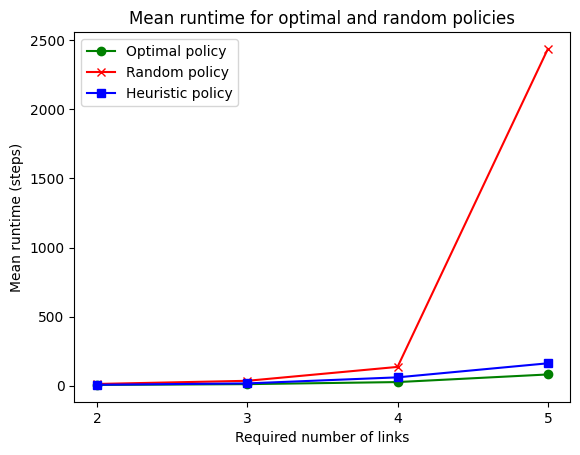

In [28]:
means_opt = []
means_random = []
means_heuristic = []

for n_links in range(2, 6):
    policy, i = pi.find_policy(n_links, f_thresh, actions, alpha, gamma, tol)
    opt_policy: dict = policy["policy"]
    print(f"Policy iteration for {n_links} links took {i} iterations")

    simulator = Simulator(opt_policy, n_links, f_thresh, actions, alpha, gamma)
    opt_samples = sim.gen_policy_samples(simulator, n_episodes)
    means_opt.append(np.mean(opt_samples))

    random_policy = {s: np.random.randint(0, len(actions)) for s in opt_policy.keys()}
    simulator = Simulator(random_policy, n_links, f_thresh, actions, alpha, gamma)
    random_samples = sim.gen_policy_samples(simulator, n_episodes)
    means_random.append(np.mean(random_samples))

    heuristic_policy = get_heuristic_policy()
    simulator = Simulator(heuristic_policy, n_links, f_thresh, actions, alpha, gamma)
    heuristic_samples = sim.gen_policy_samples(simulator, n_episodes)
    means_heuristic.append(np.mean(heuristic_samples))

plt.plot(range(2, 6), means_opt, color='g', marker='o', label='Optimal policy')
plt.plot(range(2, 6), means_random, color='r', marker='x', label='Random policy')
plt.plot(range(2, 6), means_heuristic, color='b', marker='s', label='Heuristic policy')

plt.title('Mean runtime for optimal and random policies')
plt.xlabel('Required number of links')
plt.ylabel('Mean runtime (steps)')
plt.xticks(range(2, 6))
plt.legend()
plt.show()